## EDA AND TRANSFOMATIONS

Import required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import ast

Load and transform the dataset from JSON file 

In [6]:


# Leer el archivo JSONL
data = []
with jsonlines.open("MLA_100K.jsonlines") as reader:
    for obj in reader:
        data.append(obj)

# Convertir a DataFrame
df = pd.DataFrame(data)

# Guardar como CSV
df.to_csv("NewProducts.csv", index=False)

In [8]:
# Cargar el CSV original
df = pd.read_csv("NewProducts.csv")

# Lista de columnas que contienen estructuras anidadas como strings
columnas_anidadas = [
    'seller_address', 'shipping', 'geolocation',
    'non_mercado_pago_payment_methods', 'pictures',
    'attributes', 'descriptions'
]

# Convertir strings a estructuras Python (dicts o lists)
for col in columnas_anidadas:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else None)

# ======= Extracción de campos útiles =======

# seller_address
df['latitude'] = df['seller_address'].apply(lambda x: x.get('latitude') if x else None)
df['longitude'] = df['seller_address'].apply(lambda x: x.get('longitude') if x else None)
df['country'] = df['seller_address'].apply(lambda x: x.get('country', {}).get('name') if x else None)
df['state'] = df['seller_address'].apply(lambda x: x.get('state', {}).get('name') if x else None)
df['city'] = df['seller_address'].apply(lambda x: x.get('city', {}).get('name') if x else None)
df['neighborhood'] = df['seller_address'].apply(lambda x: x.get('search_location', {}).get('neighborhood', {}).get('name') if x else None)

# shipping
df['free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping') if x else None)
df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode') if x else None)
df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up') if x else None)

# geolocation (si no es redundante con lat/lon anterior)
df['geo_lat'] = df['geolocation'].apply(lambda x: x.get('latitude') if x else None)
df['geo_lon'] = df['geolocation'].apply(lambda x: x.get('longitude') if x else None)

# pictures: contar cuántas tiene
df['num_pictures'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# métodos de pago no-mercado-pago
df['num_non_mp_methods'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# título: longitud
df['title_length'] = df['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# diferencia entre precio y precio original
df['price_diff'] = df['price'] - df['base_price']

# ======= Selección de columnas finales =======

columnas_finales = [
    'id', 'title', 'condition', 'price', 'base_price', 'price_diff',
    'sold_quantity', 'available_quantity', 'accepts_mercadopago',
    'free_shipping', 'shipping_mode', 'local_pick_up',
    'latitude', 'longitude', 'country', 'state', 'city', 'neighborhood',
    'num_pictures', 'num_non_mp_methods', 'title_length'
]

df_final = df[columnas_finales].copy()

# Guardar el resultado
df_final.to_csv("products_dataset.csv", index=False)

In [9]:
from sklearn.preprocessing import LabelEncoder

# 1. Convert 'condition' to binary target: new = 0, used = 1
df_final['condition'] = df_final['condition'].map({'new': 0, 'used': 1})

# 2. Drop non-informative or text-heavy columns
df_final = df_final.drop(columns=['id', 'title'])

# 3. Encode categorical columns using LabelEncoder
categorical_cols = ['shipping_mode', 'local_pick_up', 'country', 'state', 'city', 'neighborhood']

for col in categorical_cols:
    df_final[col] = df_final[col].astype(str)
    df_final[col] = LabelEncoder().fit_transform(df_final[col])

# 4. Final check
print("Dataset shape after encoding:", df_final.shape)
print("Ready for modeling")

# 5. Save to CSV (clean version)
df_final.to_csv("products_clean_final.csv", index=False)
print("Saved to 'products_clean_final.csv'")

Dataset shape after encoding: (100000, 19)
Ready for modeling
Saved to 'products_clean_final.csv'


Exploratory Data Analysis

 Dataset loaded: (100000, 19)

 General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   condition            100000 non-null  int64  
 1   price                100000 non-null  float64
 2   base_price           100000 non-null  float64
 3   price_diff           100000 non-null  float64
 4   sold_quantity        100000 non-null  int64  
 5   available_quantity   100000 non-null  int64  
 6   accepts_mercadopago  100000 non-null  bool   
 7   free_shipping        100000 non-null  bool   
 8   shipping_mode        100000 non-null  int64  
 9   local_pick_up        100000 non-null  int64  
 10  latitude             95398 non-null   float64
 11  longitude            95414 non-null   float64
 12  country              100000 non-null  int64  
 13  state                100000 non-null  int64  
 14  city                 10

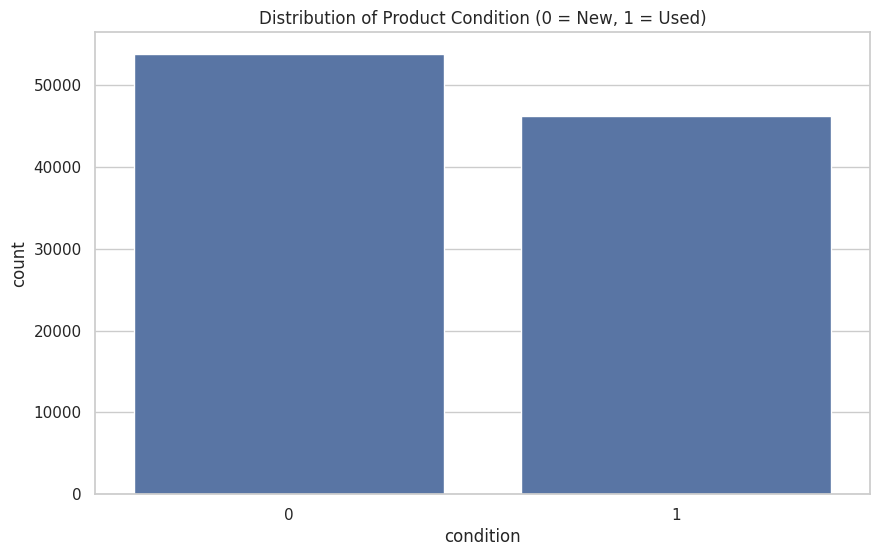

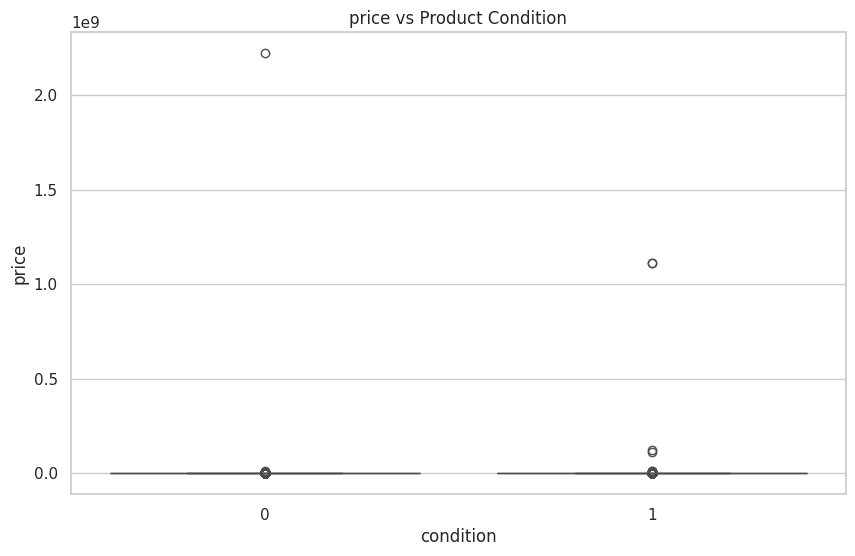

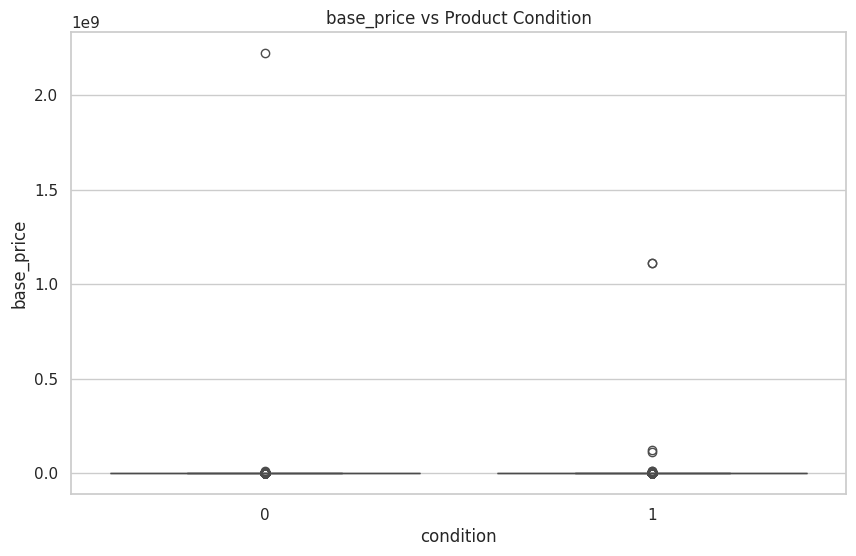

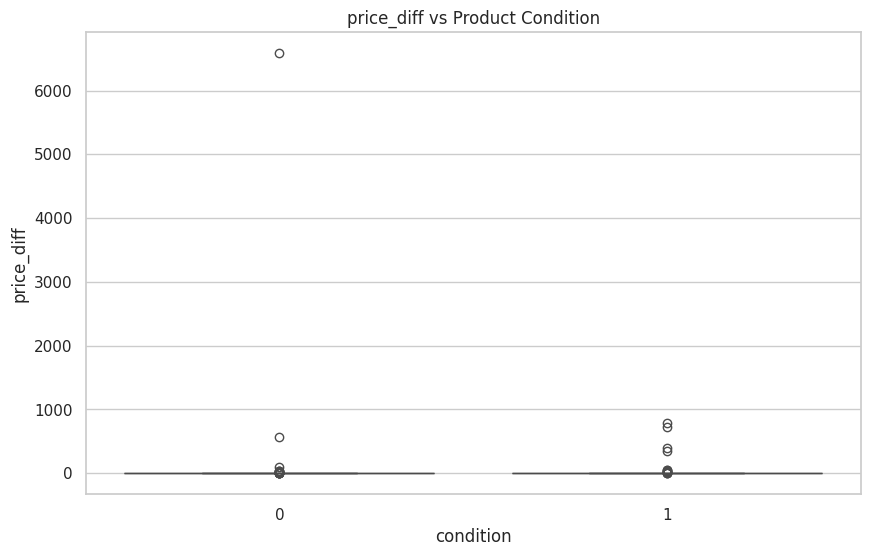

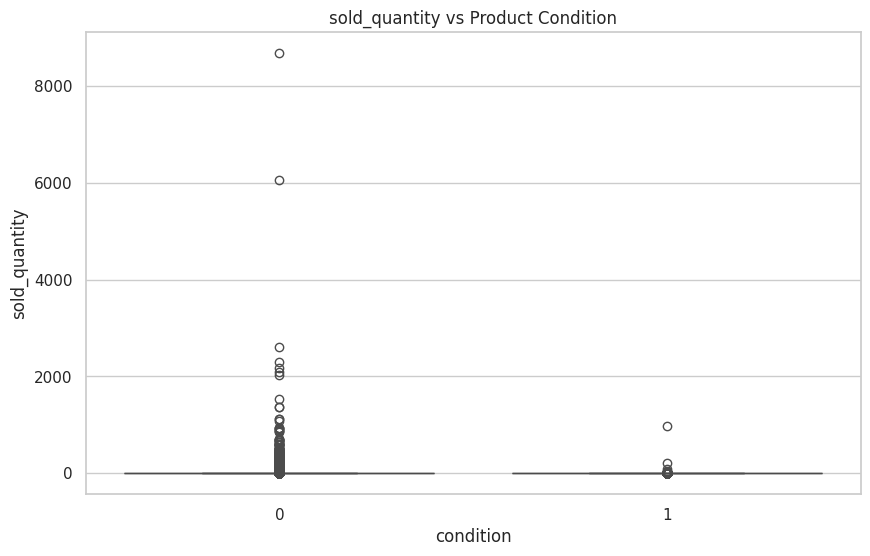

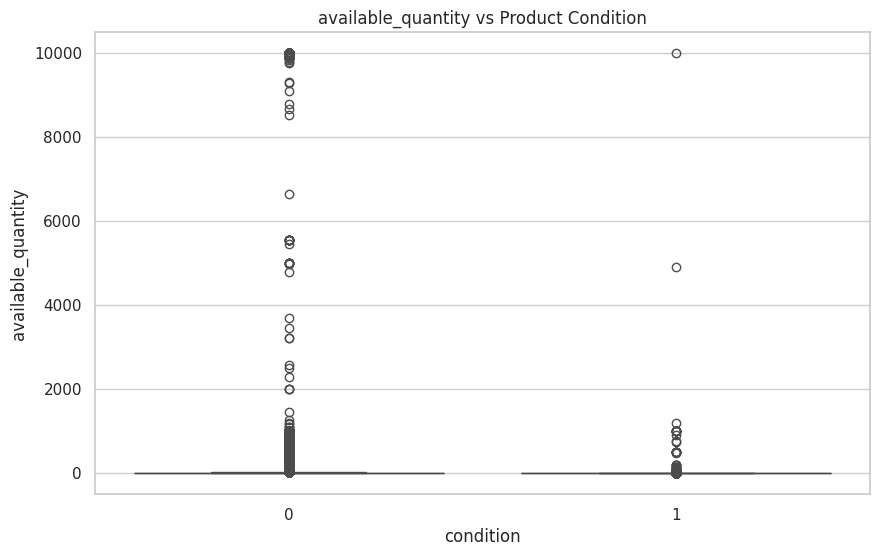

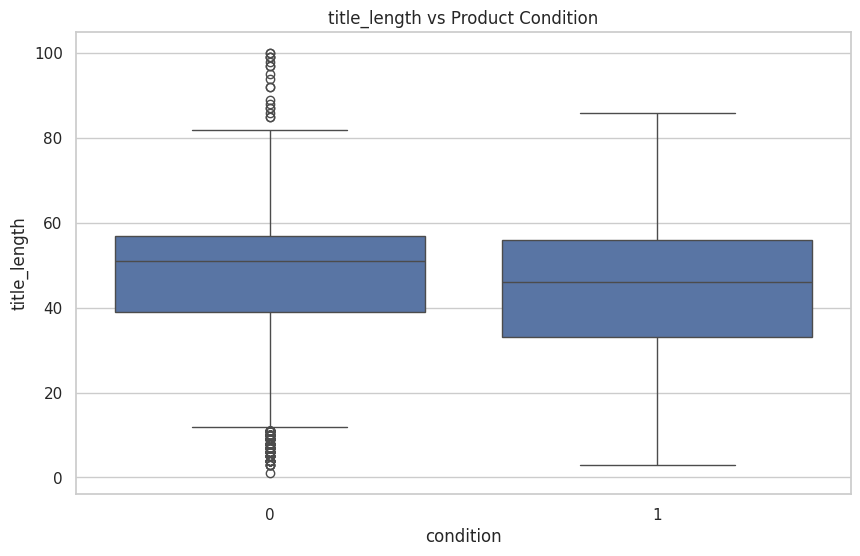

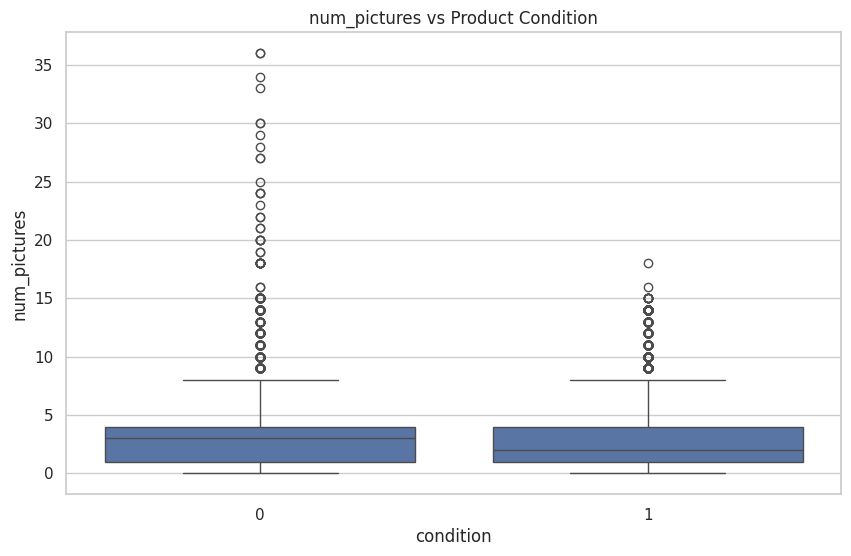

In [11]:
# Configuraciones generales
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Cargar el dataset limpio
df = pd.read_csv("products_clean_final.csv")
print(" Dataset loaded:", df.shape)

# 2. Información general del DataFrame
print("\n General Info:")
print(df.info())

# 3. Revisar valores nulos
print("\n Missing values:")
print(df.isnull().sum())

# 4. Estadísticas descriptivas
print("\n Descriptive Statistics:")
print(df.describe())

# 5. Distribución de la variable objetivo (condition: 0=new, 1=used)
sns.countplot(x='condition', data=df)
plt.title("Distribution of Product Condition (0 = New, 1 = Used)")
plt.show()


# 8. Boxplots de variables importantes frente a la condición
important_numeric = ['price', 'base_price', 'price_diff', 'sold_quantity', 'available_quantity', 'title_length', 'num_pictures']

for col in important_numeric:
    sns.boxplot(x='condition', y=col, data=df)
    plt.title(f"{col} vs Product Condition")
    plt.show()